In [1]:
import foundation
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from foundation.LLM.LLM_multi_agent import LLM_Agent2 as LLM_Agent
from foundation.LLM.behavior_tree_agent import LLM_Agent3 as tree_agent
from foundation.LLM.random_agent import LLM_Agent4 as random_agent
from foundation.LLM.ReAct import ReAct as ReAct
from foundation.LLM.Act import Act as Act
from foundation.LLM.Reflexion import Reflexion as Reflexion
from foundation.LLM.person_agent import Person_Agent
from foundation.utils import plotting
import logging
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import pandas as pd
from IPython import display
from datetime import datetime
import json
from copy import deepcopy
month_day = datetime.now().strftime("%m_%d")
logging.basicConfig(filename='../gpt3.5_' + month_day + '_cycle_70_10_off.log', level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'scenarios/sinkhole',

    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #     "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #     {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        ('Upgrade', dict(upgrade_income=10.0, upgrade_labor=1.0)),
        ('Task', dict(move_labor=1.0, collect_labor=10.0)),
        ('Recharge', dict(recharge_income=10.0, recharge_labor=1.0)),
        ('Market', dict(order_labor=1.0, max_num_orders=5)),
        ('Shop', dict(shop_labor=1.0)),
        ('Bargain', dict(bargain_labor=1.0)),
        ('LaunchReadjustment', dict(is_biadjustment=True, adjustment_period=50, adjustment_rate_max=0.2, adjustment_rate_min=0.0, adjustment_rate_bin=0.1))
    ],

    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'base_launch_plan': {
        'Exp': 70,
        'Mat': 200,
        'Token': 70
    },
    'starting_player_token': 0,
    'starting_player_currency': 200,
    'normal_wear_and_tear_rate': 0.05,
    'player_monetary_cost_dist': 'pareto', 
    'player_nonmonetary_cost_dist': 'normal',
    'player_utility_income_fxrate': 0.2,
    'adjustemt_type': 'none', #'planner',
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 10,          # Number of non-planner agents (must be >1)
    'world_size': [50, 50],  # [Height, Width] of the env world
    'episode_length': 1000,  # Number of timesteps per episode
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    'allow_observation_scaling': True,
    'full_observability': False,
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': False,
    'seed':42,
}

In [3]:
def sample_LLM_action(args):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    agent, a_obs, resources_maps, agent_locs, llm_agent = args
    
    if agent.multi_action_mode:
        # split_masks = np.split(a_obs['action_mask'], agent.action_spaces.cumsum()[:-1])
        # return agent.idx,  [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]
        return [0 for _ in range(len(a_obs['action_mask']))]
    # Return a single action
    else:
        market_hist = {}
        market_hist['market_rate'] = a_obs['Market-market_rate-Mat']
        market_hist['available_asks'] = a_obs['Market-available_asks-Mat']
        market_hist['available_bids'] = a_obs['Market-available_bids-Mat']
        market_hist['my_asks'] = a_obs['Market-my_asks-Mat']
        market_hist['my_bids'] = a_obs['Market-my_bids-Mat']
        market_hist['all_ask_hists'] = a_obs['Market-all_asks-Mat']
        # llm_agent = llm_agents[agent.idx]
        action = llm_agent.generate_action(agent.inventory, agent.escrow, agent.endogenous['Capability'], resources_maps, agent_locs, market_hist, bargain_message = a_obs.get('Bargain-bargain_msg', None), masks=a_obs['action_mask'])
        '''print(action)
        print(llm_agent.step)'''
        # llm_agents[agent.idx] = llm_agent
        #return llm_agent.generate_action(agent.inventory, agent.endogenous['Capability'], resources_maps, agent_locs, market_hist, bargain_message = a_obs.get('Market-bargain_msg-Mat', None))
        return action


def sample_LLM_actions(env, obs, LLM_agents, executor, multithread = True):
    """Samples random UNMASKED actions for each agent in obs."""
    maps = env.world.maps
    resource = ['Exp', 'Mat', 'Token']
    resources_maps = {k : maps.get(k) for k in resource}
  
    actions = {}
    agent_locs = [agent.loc for agent in env.world.agents]
   
    if multithread:
        chunks = [(env.get_agent(a_idx), a_obs, resources_maps, agent_locs, LLM_agents[int(a_idx)] if a_idx != 'p' else None) for a_idx, a_obs in obs.items() if a_idx == 'p' or not isinstance(LLM_agents[int(a_idx)], Person_Agent)]
        for idx, action in zip(
            obs.keys(),
            executor.map(sample_LLM_action, chunks),
        ):
            actions[idx] = action

    for a_idx, a_obs in obs.items():
        if a_idx != 'p' and isinstance(LLM_agents[int(a_idx)], Person_Agent):
            idx, action = sample_LLM_action((env.get_agent(a_idx), a_obs, resources_maps, agent_locs, LLM_agents[int(a_idx)]))
            actions[int(a_idx)] = action
    # print(results)
    #actions = {a_idx:action for a_idx, llm_agent,action in results}
    
    # LLM_agents = {a_idx : dill.loads(llm_agent) for a_idx,llm_agent,_ in results if a_idx != 'p'}
    return actions

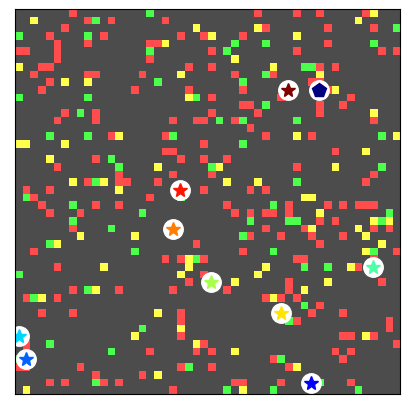

In [4]:
env = foundation.make_env_instance(**env_config)
env.reset()
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
plotting.do_plot(env, ax1, fig)
display.clear_output(wait=True)
all_asks, all_bids = [], []

In [5]:

LLM_agents = {}
# profiles = ['grind','pay','balance','seller','grind']
df = pd.read_csv('profiles3.csv')
profiles = df['player_profile'].tolist()[:env.n_agents]
profiles2 = ["You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability." for _ in range(5)]
profiles = profiles2 + profiles
off_rates = [0 for _ in range(5)] + df['off_rate'].tolist()[:env.n_agents]
print(profiles)
print(off_rates)
n_profile = len(profiles)
for i in range(env.n_agents):
    if i >= 30:
        # LLM_agents[i] = random_agent(player_profile=None, agent_id=i)
        LLM_agents[i] = tree_agent(player_profile=None, agent_id=i)
    else:
        LLM_agents[i] = LLM_Agent(player_profile=profiles[i%n_profile], agent_id=i, off_rate=off_rates[i])
        # LLM_agents[i] = ReAct(player_profile=profiles[i%n_profile], agent_id=i)
        # LLM_agents[i] = Reflexion(player_profile=profiles[i%n_profile], agent_id=i)
        # LLM_agents[i] = Act(player_profile=profiles[i%n_profile], agent_id=i)
decision_seqs = [[] for i in range(env.n_agents)]

["You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You invest both time and money in the game. You perfer put your effort in trading with other players and make profit from it, and your main goal is improving your game role's capability.", "You are highly active in the game, focusing on g

In [6]:

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.

    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop

    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
    
    file = open('output_actions_0521.txt', 'a')
    file.write('Starting Game! \n')
    
    # Testing!
    obs = env.reset(force_dense_logging=do_dense_logging)
    # obs = env._generate_observations()
    adjustment_rates = env.components[-1].adjustment_rates
    
    plotting.do_plot(env, ax1, fig)

    with ThreadPoolExecutor(max_workers=10) as executor:
        for t in range(env.episode_length):
            logging.info('Step ' + str(t) + '======================================= \n')
            actions = sample_LLM_actions(env, obs, LLM_agents, executor)
            logging_actions = deepcopy(actions)
            for k,v in actions.items():
                if k == 'p':
                    del logging_actions[k]
                else:
                    '''k = int(k)
                    if isinstance(v, dict):
                        decision_seqs[int(k)].append(list(v.keys())[0])
                    else:
                        decision_seqs[int(k)].append("Offline")'''
                    k = int(k)
                    if isinstance(LLM_agents[k], Person_Agent):
                        logging_actions[k] = {'action':v, 'type':'Person'}
                    elif isinstance(LLM_agents[k], LLM_Agent):
                        logging_actions[k] = {'action':v, 'type':'LLM'}
                    elif isinstance(LLM_agents[k], ReAct):
                        logging_actions[k] = {'action':v, 'type':'ReAct'}
                    elif isinstance(LLM_agents[k], Reflexion):
                        logging_actions[k] = {'action':v, 'type':'Reflexion'}
                    else:
                        logging_actions[k] = {'action':v, 'type':'Random'}
            file.write(json.dumps(logging_actions) + '\n')

            all_asks.append((obs["2"]['Market-available_asks-Mat'] + obs["2"]['Market-my_asks-Mat']).tolist())
            all_bids.append((obs["2"]['Market-available_bids-Mat'] + obs["2"]['Market-my_bids-Mat']).tolist())
            if t % 10 == 9:
                trades_file = open('trades_0521.txt','w')
                trades_file.write(json.dumps([all_asks, all_bids]))
            if t % 50 == 49:
                dense_log_file = open('dense_log_cp.json', 'w')
                env._finalize_logs()
                dense_log = env.previous_episode_dense_log
                dense_log_file.write(json.dumps(dense_log))
            obs, rew, done, info = env.step(actions)
            display.clear_output(wait=True)
            ax2.clear()

            readjustment_plan = {k:adjustment_rates[int(v)-1] if v!=0 else 0 for k,v in zip(["Exp", "Mat", "Token"], actions['p'])}
            planner_launch_plan = {k: int(env.base_launch_plan[k]*(1+v)) for k, v in readjustment_plan.items()}
            for k,v in readjustment_plan.items():
                if v==0:
                    readjustment_plan[k] = 'NO-OP'
                elif v>0:
                    readjustment_plan[k] = '+' + str(v*100) + '%'
                else:
                    readjustment_plan[k] = '-' + str(abs(v)*100) + '%'
            
            text = 'Steps: ' + str(t) + ' Durations: ' + str(env._durations) +'\n'
            text += 'Default launch plan: ' + str(env.base_launch_plan) + '\n'
            text += 'Current launch plan: ' + str(env.curr_launch_plan) + '\n'
            text += 'Last launch plan: ' + str(env.last_launch_plan) + '\n\n'

            metrics = env.scenario_metrics()
            text += 'Profitability: ' + str(round(metrics['social/productivity'], 2))+ ', Equality: ' +  str(round(metrics['social/equality'], 2)) +'\n'
            text += 'Planner: '+ str(readjustment_plan) +'\n'
            text += 'Planner launch plan: ' + str(planner_launch_plan)+ '\n\n\n'

            for i in range(len(env.all_agents)-1):
                act = env.dense_log["actions"][t][str(i)]
                act = act if len(act) > 0 else {'NO-OP': 1}
                decision_seqs[i].append(list(act.keys())[0])
                text += 'Agent: ' + str(i) + ' :\nAction: ' + str(act) + '\nInventory: ' + str(env.world.agents[i].inventory) + '\nescrow: ' + str(
                    env.world.agents[i].escrow) + '\nEndogenous: ' + str(
                    env.world.agents[i].endogenous) + '\n================================\n'
            ax2.text(0.05, 0., text, fontsize=18)
            plt.xticks([])
            plt.yticks([])

            if ((t+1) % plot_every) == 0:
                plotting.do_plot(env, ax1, fig)

    if ((t+1) % plot_every) != 0:
        plotting.do_plot(env, ax1, fig)

    for idx in range(len(LLM_agents)):
        print('agent ' + str(idx) + '\'s total online steps: ' + str(LLM_agents[idx].total_online_steps))
        if isinstance(LLM_agents[idx], LLM_Agent):
            print('agent ' + str(idx) + '\'s total LLM numbers: ' + str(LLM_agents[idx].LLM_number))
    
    


In [ ]:
play_random_episode(env, plot_every=1, do_dense_logging=True)